In [1]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%cd '../'

/Users/lolo/quantic/science/HomeHots/HOTS_clone_laurent


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time

from HOTS.ToolsMonitor import GenerateActivationMap, DisplayActivationMap
from HOTS.Event import Event, SimpleAlphabet, LoadNMNIST
from HOTS.STS import STS
from HOTS.Layer import ClusteringLayer
from HOTS.ToolsMonitor import (
    DisplayImage,
    DisplaySurface3D,
    DisplaySurface2D,
    DisplayConvergence,
)
from HOTS.Tools import SaveObject, LoadObject
from HOTS.Classifier import Classifier
from HOTS.Network import Network
from HOTS.KmeansLagorce import KmeansLagorce
from HOTS.KmeansMaro import KmeansMaro
from HOTS.Event import conv2eve

tau = 9e-4 # -> tau=1ms, si on prend 10 ms on est à 1s pour la dernière couche et les vidéos font 0.3s en moyenne
R = 2
filthr = 2
nbkNN = 3
algo = 'lagorce'
decay = 'exponential'
hom = True
krnlinit = 'rdn'
nb_cluster = [4, 8, 16]
ImageSize = (34, 34)
DataPath = 'Data/testsetnmnist.p'

NbClusteringData = 15
NbTrainingData = 40
NbTestingData = 40
_1ofich = True
event_tr, event_te, event_cl, label_tr, label_te = LoadNMNIST(
NbTrainingData, NbTestingData, NbClusteringData, OneOfEach=_1ofich, Path=DataPath, OutOnePolarity=False, ListPolarities=None, verbose=0)

[3, 1, 6, 7, 2, 4, 8, 9, 0, 5]


In [3]:
#timestr = time.strftime("%Y%m%d")
hom = False
timestr = '20201021'
if hom==True:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'_homeo.pkl'
else:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'.pkl'
print(fname)

L1 = ClusteringLayer(tau=tau,R=R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L2 = ClusteringLayer(tau=10 * tau,R=2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
L3 = ClusteringLayer(tau=10 * 10 * tau,R=2 * 2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=hom,init=krnlinit)
Net = Network([L1, L2, L3])

if not os.path.isfile(fname):
    ClusterLayer, event_output = Net.TrainCluster(
            event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=1
        )
    SaveObject(ClusterLayer, fname)
else: 
    ClusterLayer, Classif0 = LoadObject(fname)

prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

Records/EXP_03_NMNIST/20201021_hots_0.9ms_lagorce.pkl
battacha:52.5% ### normalized:42.5% ### euclidian:45.0% ### 


### Loading only on digit of each for logistic regression

In [4]:
homrun = False
event0_o_tr2 = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
event0_o_te2 = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)
Classif02 = Classifier(event0_o_tr2, event0_o_te2, TrainingLabel=label_tr, GroundTruth=label_te)
prediction2, accuracy2, method2 = Classif02.HistogramDistance(knn=nbkNN, to_print=True)

battacha:35.0% ### normalized:40.0% ### euclidian:37.5% ### 


### Building matrix for logistic regression

Number of events: 39822 - Number of features: 18496


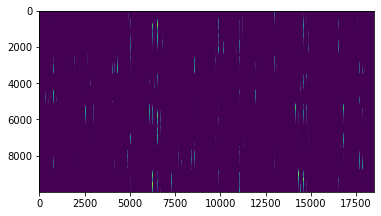

In [5]:
imlen = ImageSize[0]*ImageSize[1]
taucla = 1e-2
X = np.zeros([len(Classif02.event_train.time), imlen*nb_cluster[-1]])
y = np.zeros([len(Classif02.event_train.time)])
addr = Classif02.event_train.address[0]*ImageSize[0]+Classif02.event_train.address[1]+imlen*Classif02.event_train.polarity[0]
X[0][addr]=1
y[0] = Classif02.GroundTruth[0]
il = 0
for i in range(1,len(Classif02.event_train.time)):
    if i-1 not in Classif02.event_train.ChangeIdx:
        X[i] = X[i-1]*np.exp((Classif02.event_train.time[i-1]-Classif02.event_train.time[i])/taucla)
    else:
        il += 1
    addr = Classif02.event_train.address[i][0]*ImageSize[0]+Classif02.event_train.address[i][1]+imlen*Classif02.event_train.polarity[i]
    X[i][addr] = 1
    y[i] = Classif02.GroundTruth[il]
plt.imshow(X[:10000]);
print('Number of events: '+str(X.shape [0])+' - Number of features: '+str(X.shape [1]))
SaveObject([X,y], 'vectorzLR.pkl')

### Building subsampled matrix for logistic regression (taking 1 sample over 'subcoef')

In [6]:
subcoef = 10
Xlr, ylr = LoadObject('vectorzLR.pkl')
Xlrsub = Xlr[::subcoef,:]
ylrsub = ylr[::subcoef]

### Building matrix for logistic regression taking only polarities

In [7]:
taucla = 1e-2
Xhisto = np.zeros([len(Classif02.event_train.time), nb_cluster[-1]])
yhisto = np.zeros([len(Classif02.event_train.time)])
addr = Classif02.event_train.polarity[0]
Xhisto[0][addr]=1
yhisto[0] = Classif02.GroundTruth[0]
il = 0
for i in range(1,len(Classif02.event_train.time)):
    if i-1 not in Classif02.event_train.ChangeIdx:
        Xhisto[i] = Xhisto[i-1]*np.exp((Classif02.event_train.time[i-1]-Classif02.event_train.time[i])/taucla)
    else:
        il += 1
    addr = Classif02.event_train.polarity[i]
    Xhisto[i][addr] = 1
    yhisto[i] = Classif02.GroundTruth[il]
print('Number of events: '+str(Xhisto.shape [0])+' - Number of features: '+str(Xhisto.shape [1]))
SaveObject([Xhisto,yhisto], 'vecthistLR.pkl')

Number of events: 39822 - Number of features: 16


### Performing logistic regression using cross-validation

In [ ]:
from sklearn.linear_model import LogisticRegressionCV as LogReg
lrsub = LogReg(random_state=0).fit(Xlr,ylr)

### Performing logistic regression on the subsampled matrix using cross-validation

In [ ]:
from sklearn.linear_model import LogisticRegressionCV as LogReg
lrsub = LogReg(random_state=0).fit(Xlrsub,ylrsub)

### Performing logistic regression on the matrix of polarities only

In [ ]:
from sklearn.linear_model import LogisticRegression as LR
lrpol = LR(random_state=0).fit(Xhisto,yhisto)

In [ ]:
lrpol.score(Xhisto,yhisto)

## Other things ...

In [ ]:
from sklearn.decomposition import PCA
from HOTS.Tools import GenerateHistogram
histo_train, pola_train = GenerateHistogram(Classif0.event_train)
pca = PCA(n_components=2)
pca.fit(histo_train)

In [ ]:
ax = []
a = np.dot(histo_train,pca.components_.T)
for i in range(10):
    ilab = np.where(Classif0.GroundTruth==[str(float(i))])[0]
    scatx = np.zeros([len(ilab)])
    scaty = np.zeros([len(ilab)])
    k=0
    for j in ilab:
        scatx[k] = a[j][0]
        scaty[k] = a[j][1]
        k+=1
    ax += plt.plot(scatx,scaty, '*', label=str(i))
labelz = [l.get_label() for l in ax]
plt.legend(ax, labelz)
plt.show()

In [ ]:
Classif0.event_train.ChangeIdx

In [ ]:
from sklearn.decomposition import PCA
from HOTS.Tools import GenerateHistogram
nbevents = 500
output = np.zeros([Classif0.event_train.ChangeIdx.shape[0],nbevents])
output[0] = Classif0.event_train.polarity[:nbevents]
for i in range(Classif0.event_train.ChangeIdx.shape[0]):
    output[i] = Classif0.event_train.polarity[Classif0.event_train.ChangeIdx[i]:Classif0.event_train.ChangeIdx[i]+nbevents]
pca = PCA(n_components=2)
pca.fit(output)

In [ ]:
ax = []
a = np.dot(output,pca.components_.T)
for i in range(10):
    ilab = np.where(Classif0.GroundTruth==[str(float(i))])[0]
    scatx = np.zeros([len(ilab)])
    scaty = np.zeros([len(ilab)])
    k=0
    for j in ilab:
        scatx[k] = a[j][0]
        scaty[k] = a[j][1]
        k+=1
    ax += plt.plot(scatx,scaty, '*', label=str(i))
labelz = [l.get_label() for l in ax]
plt.legend(ax, labelz)
plt.show()

## scratchboard

In [ ]:
a = [1e-5,1e-4,5e-4,1e-3,2.5e-3,4e-3,5e-3,1e-2,2e-2]
for idx in a:
    print(idx)

In [ ]:
*map(lambda x: 3 * x**2, Classif0.event_train.ChangeIdx),

In [ ]:
import numpy as np
a = np.ones([10])*100
for i in range(200):
    if i in a:
        print(i, np.where(a==i))

In [ ]:
x = np.linspace(0,1,50)

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
N = 4
valmin = 0.7
valmax = 1.3
n = 1
p = 1
x = np.linspace(0,1,50)
f1 = np.exp((x-1/N)*-N)
N = 8
f2 = np.exp((x-1/N)*N)
N = 16
f3 = np.exp((x-1/N)*N)
N = 32
f4 = np.exp((x-1/N)*N)
j1 = np.log(np.exp(1)*(N-1)*x/(p-x/p))
p = 2
j2 = np.log(np.exp(1)*(N-1)*x/(p-x/p))
p = 3
j3 = np.log(np.exp(1)*(N-1)*x/(p-x/p))
b = np.log(valmax)*np.log(valmin)/((N-1)*np.log(valmin)+np.log(valmax))
d = b/np.log(valmin)
a = -b*N
k = np.exp((a*x+b)/(d-x))
valmin = 0.6
valmax = 2*1.4
b = np.log(valmax)*np.log(valmin)/((N-1)*np.log(valmin)+np.log(valmax))
d = b/np.log(valmin)
a = -b*N
k2 = np.exp((a*x+b)/(d-x))
valmin = 0.5
valmax = 2*1.5
b = np.log(valmax)*np.log(valmin)/((N-1)*np.log(valmin)+np.log(valmax))
d = b/np.log(valmin)
a = -b*N
k3 = np.exp((a*x+b)/(d-x))
l = np.log(x+0.2)
m = -np.log(1-(x+0.2))
N = 8
h = np.log(x)/np.log(1/N)
plt.plot(x,f1, x,h)

In [ ]:
a = np.ones([20,2])*25
print(np.sum(a)*a)
print(np.sum(np.sqrt(a), axis=0))